## ANOVA
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/anova/how-to/one-way-anova/interpret-the-results/key-results/
- https://www.reneshbedre.com/blog/anova.html




## ANOVA + TUKEY
- https://towardsdatascience.com/anova-tukey-test-in-python-b3082b6e6bda
- https://blog.4dcu.be/programming/2021/12/30/Posthoc-Statannotations.html

In [163]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import f_oneway
from scikit_posthocs import posthoc_tukey


DATA_PATH = 'data/all_metrics_lola11'
METRIC = 'Dice Coefficient'
METRIC = 'Jaccard Index'

file_dict = {
    'DET2': 'metrics_detectron2.csv',
    'LMASK': 'metrics_lungmask.csv',
    'P_DET2': 'metrics_pneumonia_detectron2.csv',
    'P_MASK': 'metrics_pneumonia_lungmask.csv',
    'P_SAM': 'metrics_pneumonia_sam.csv',
    'PNM': 'metrics_pneumonia.csv',
    'SAM': 'metrics_sam.csv'
}


In [164]:
# Function to read the file and return the data for the selected metric
def read_metric(file_path, metric, key):
    df = pd.read_csv(file_path)
    return df[metric].values

# Dictionary to store the metric data
data = {}


# Read the data from each file and store it in the dictionary
for key, file_path in file_dict.items():
    data[key] = read_metric(path.join('..', DATA_PATH, file_path), METRIC, key)

# Create the consolidated DataFrame
consolidated_df = pd.DataFrame(data)

consolidated_df.head()

,DET2,LMASK,P_DET2,P_MASK,P_SAM,PNM,SAM
0,0.5949,0.0119,0.7107,0.7311,0.7722,0.7599,0.6863
1,0.4569,0.0188,0.6710,0.5851,0.5972,0.5993,0.5750
2,0.3935,0.7248,0.6159,0.7247,0.6654,0.7094,0.4707
3,0.3627,0.6966,0.5881,0.6973,0.7517,0.6208,0.5982
4,0.3048,0.7113,0.5534,0.7122,0.6817,0.6727,0.5458


In [165]:
consolidated_df.shape

(55, 7)

In [166]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(consolidated_df.reset_index(), id_vars=['index'], value_vars=file_dict.keys())
# replace column names
df_melt.columns = ['index', 'treatments', 'value']


f_value, p_value = f_oneway(*[consolidated_df[col] for col in consolidated_df.columns])
print(f"F-value: {f_value}, P-value: {p_value}\n")


print(f"{METRIC} means \n")
print(consolidated_df.mean())

# Perform ANOVA
model = ols('value ~ C(treatments)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


# Check if ANOVA is significant
if anova_table['PR(>F)'][0] <= 0.05:
    # Perform Tukey's HSD test
    tukey = pairwise_tukeyhsd(endog=df_melt['value'], groups=df_melt['treatments'], alpha=0.05)
    print(tukey)
else:
    print("ANOVA is not significant; no need to perform Tukey's test.")



F-value: 16.77217037973436, P-value: 3.5224593329852633e-17

Jaccard Index means 

DET2      0.509122
LMASK     0.676311
P_DET2    0.651907
P_MASK    0.699915
P_SAM     0.710124
PNM       0.634245
SAM       0.575069
dtype: float64
                 sum_sq     df         F        PR(>F)
C(treatments)  1.719739    6.0  16.77217  3.522459e-17
Residual       6.459720  378.0       NaN           NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  DET2  LMASK   0.1672    0.0  0.0933  0.2411   True
  DET2    PNM   0.1251    0.0  0.0512   0.199   True
  DET2 P_DET2   0.1428    0.0  0.0689  0.2167   True
  DET2 P_MASK   0.1908    0.0  0.1169  0.2647   True
  DET2  P_SAM    0.201    0.0  0.1271  0.2749   True
  DET2    SAM   0.0659 0.1156 -0.0079  0.1398  False
 LMASK    PNM  -0.0421 0.6249  -0.116  0.0318  False
 LMASK P_DET2  -0.0244 0.9583 -0.0983  0.0495  False
 LMASK P_MASK   0.023

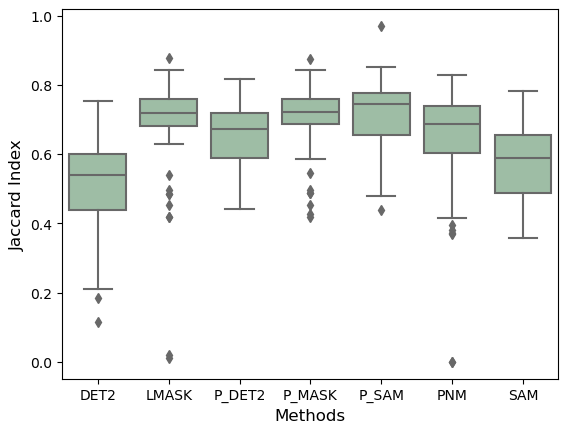

,index,treatments,value
0,0,DET2,0.5949
1,1,DET2,0.4569
2,2,DET2,0.3935
3,3,DET2,0.3627
4,4,DET2,0.3048
...,...,...,...
380,50,SAM,0.5219
381,51,SAM,0.3688
382,52,SAM,0.6707
383,53,SAM,0.5143


In [183]:
import pandas as pd


# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(consolidated_df.reset_index(), id_vars=['index'], value_vars=file_dict.keys())
# replace column names
df_melt.columns = ['index', 'treatments', 'value']

# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='treatments', y='value', data=df_melt, color='#99c2a2')
ax.set_xlabel("Methods", fontsize=12)
ax.set_ylabel(METRIC, fontsize=12)
# ax = sns.swarmplot(x="treatments", y="value", data=df_melt, color='#7d0013')
plt.show()
df_melt

In [185]:
from scikit_posthocs import posthoc_tukey

# First we do a oneway ANOVA as implemented in SciPy
# print(stats.f_oneway(*data))

tukey_df = posthoc_tukey(df_melt, val_col="value", group_col="treatments")
tukey_df


,DET2,LMASK,P_DET2,P_MASK,P_SAM,PNM,SAM
DET2,1.000000,0.001000,0.001000,0.001000,0.001000,0.001000,0.115797
LMASK,0.001000,1.000000,0.900000,0.900000,0.801357,0.607704,0.001156
P_DET2,0.001000,0.900000,1.000000,0.466141,0.229996,0.900000,0.035551
P_MASK,0.001000,0.900000,0.466141,1.000000,0.900000,0.119006,0.001000
P_SAM,0.001000,0.801357,0.229996,0.900000,1.000000,0.039824,0.001000
PNM,0.001000,0.607704,0.900000,0.119006,0.039824,1.000000,0.212620
SAM,0.115797,0.001156,0.035551,0.001000,0.001000,0.212620,1.000000


In [186]:
remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan

molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df


,index,variable,value
7,DET2,LMASK,0.001000
14,DET2,P_DET2,0.001000
15,LMASK,P_DET2,0.900000
21,DET2,P_MASK,0.001000
22,LMASK,P_MASK,0.900000
23,P_DET2,P_MASK,0.466141
28,DET2,P_SAM,0.001000
29,LMASK,P_SAM,0.801357
30,P_DET2,P_SAM,0.229996
31,P_MASK,P_SAM,0.900000


In [202]:
consolidated_df.head()
df_melt.head()

,index,treatments,value
0,0,DET2,0.5949
1,1,DET2,0.4569
2,2,DET2,0.3935
3,3,DET2,0.3627
4,4,DET2,0.3048


DET2 vs. LMASK: Custom statistical test, P_val:1.000e-03
LMASK vs. P_DET2: Custom statistical test, P_val:9.000e-01
P_DET2 vs. P_MASK: Custom statistical test, P_val:4.661e-01
P_MASK vs. P_SAM: Custom statistical test, P_val:9.000e-01
P_SAM vs. PNM: Custom statistical test, P_val:3.982e-02
PNM vs. SAM: Custom statistical test, P_val:2.126e-01
DET2 vs. P_DET2: Custom statistical test, P_val:1.000e-03
LMASK vs. P_MASK: Custom statistical test, P_val:9.000e-01
P_DET2 vs. P_SAM: Custom statistical test, P_val:2.300e-01
P_MASK vs. PNM: Custom statistical test, P_val:1.190e-01
P_SAM vs. SAM: Custom statistical test, P_val:1.000e-03
DET2 vs. P_MASK: Custom statistical test, P_val:1.000e-03
LMASK vs. P_SAM: Custom statistical test, P_val:8.014e-01
P_DET2 vs. PNM: Custom statistical test, P_val:9.000e-01
P_MASK vs. SAM: Custom statistical test, P_val:1.000e-03
DET2 vs. P_SAM: Custom statistical test, P_val:1.000e-03
LMASK vs. PNM: Custom statistical test, P_val:6.077e-01
P_DET2 vs. SAM: Custom 

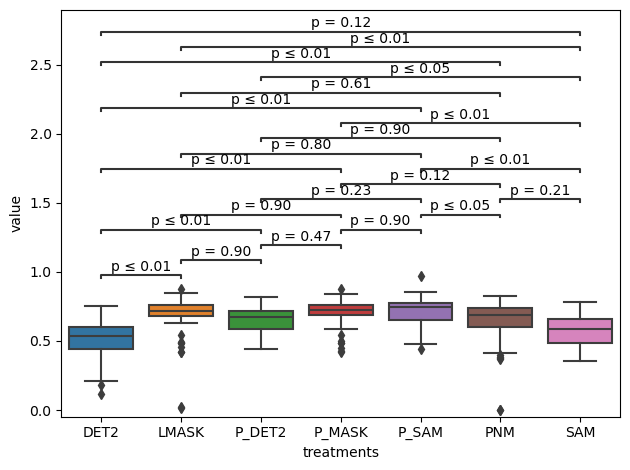

In [225]:
# https://github.com/trevismd/statannotations-tutorials/blob/main/Tutorial_1/Statannotations-Tutorial-1.ipynb

import seaborn as sns
from statannotations.Annotator import Annotator

ax = sns.boxplot(data=df_melt, x="treatments", y="value")

pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]
p_values = [i[1]["value"] for i in molten_df.iterrows()]


annotator = Annotator(
    ax, pairs, data=df_melt, x="treatments", y="value"
)
# annotator.configure(text_format="star", loc="inside", verbose=2)
annotator.configure(text_format="simple")

# Filter p-values for annotation
# p_values_leq_005 = [p_val if p_val <= 0.05 else None for p_val in p_values]
# p_values_leq_001 = [p_val if p_val <= 0.01 else None for p_val in p_values]


significant_pairs = [pairs[i] for i in range(len(p_values)) if p_values[i] <= 0.05]

# annotator._pvalue_format.pvalue_thresholds =  [[0.05, '*'], [-1000, '']]


annotator.set_pvalues_and_annotate(p_values)

plt.tight_layout()


# Examples

In [113]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
f_value, p_value = f_oneway(*[consolidated_df[col] for col in consolidated_df.columns])
print(f_value, p_value)

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

12.299118885309667 1.1759849336193577e-12


,sum_sq,df,F,PR(>F)
C(treatments),1.100698,6.0,12.299119,1.175985e-12
Residual,5.638123,378.0,NaN,NaN


In [115]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary
# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results.

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),6.0,1.100698,0.183450,12.299119,1.175985e-12
Residual,378.0,5.638123,0.014916,NaN,NaN


In [6]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Converter para formato longo
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
df_melt.columns = ['index', 'treatments', 'value']

# Verificar se todos os valores são numéricos
df_melt['value'] = pd.to_numeric(df_melt['value'], errors='coerce')

# Remover quaisquer linhas com valores não numéricos
df_melt = df_melt.dropna(subset=['value'])

# Realizar a ANOVA
model = ols('value ~ C(treatments)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Result:")
print(anova_table)

# Verificar se a ANOVA é significativa
if anova_table['PR(>F)'][0] < 0.05:
    # Realizar o Teste de Tukey
    tukey = pairwise_tukeyhsd(endog=df_melt['value'], groups=df_melt['treatments'], alpha=0.05)
    print("\nTukey HSD Result:")
    print(tukey)
else:
    print("ANOVA não é significativa; não há necessidade de realizar o teste de Tukey.")


ANOVA Result:
                sum_sq    df         F    PR(>F)
C(treatments)  3010.95   3.0  17.49281  0.000026
Residual        918.00  16.0       NaN       NaN


/var/folders/4d/7pshjxj13f91ntw0zt1jz2br0000gn/T/ipykernel_27506/1628329345.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:



Tukey HSD Result:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B     15.4 0.0251   1.694 29.106   True
     A      C      1.6 0.9867 -12.106 15.306  False
     A      D     30.4 0.0001  16.694 44.106   True
     B      C    -13.8 0.0482 -27.506 -0.094   True
     B      D     15.0 0.0296   1.294 28.706   True
     C      D     28.8 0.0001  15.094 42.506   True
---------------------------------------------------


In [20]:
df_melt

,index,treatments,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29
5,0,B,45
6,1,B,55
7,2,B,29
8,3,B,56
9,4,B,40


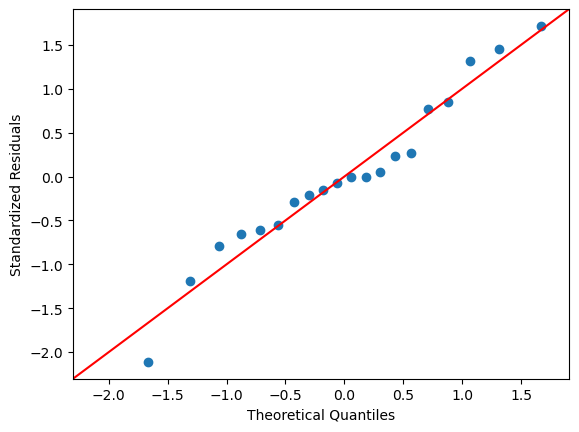

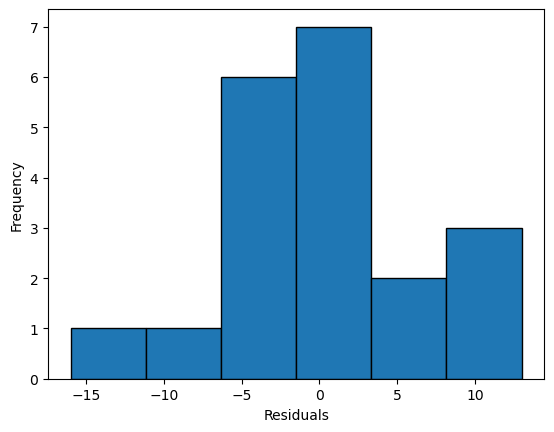

In [8]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [9]:
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.9685019850730896 0.7229772806167603


In [11]:
import scipy.stats as stats
w, pvalue = stats.bartlett(df['A'], df['B'], df['C'], df['D'])
print(w, pvalue)

from bioinfokit.analys import stat 
res = stat()
res.bartlett(df=df_melt, res_var='value', xfac_var='treatments')
res.bartlett_summary

5.687843565012841 0.1278253399753448


,Parameter,Value
0,Test statistics (T),5.6878
1,Degrees of freedom (Df),3.0000
2,p value,0.1278


In [12]:
# if you have a stacked table, you can use bioinfokit v1.0.3 or later for the Levene's test
from bioinfokit.analys import stat 
res = stat()
res.levene(df=df_melt, res_var='value', xfac_var='treatments')
res.levene_summary


,Parameter,Value
0,Test statistics (W),1.9220
1,Degrees of freedom (Df),3.0000
2,p value,0.1667


In [14]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Exemplo de conjunto de dados
data = {
    'Yield': [25, 30, 28, 36, 29, 45, 55, 29, 56, 40, 30, 60, 33, 51, 27, 54, 73, 62],
    'Genotype': ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D'],
    'Year': [1, 1, 2, 2, 3, 1, 1, 2, 2, 3, 1, 1, 2, 2, 3, 1, 2, 3]
}

df = pd.DataFrame(data)

# Realizando ANOVA de duas vias
model = ols('Yield ~ C(Genotype) + C(Year) + C(Genotype):C(Year)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Se os valores p (PR(>F)) para qualquer um destes componentes forem menores que 0.05, 
# você rejeita a hipótese nula correspondente, indicando um efeito significativo.


                          sum_sq   df         F    PR(>F)
C(Genotype)          2235.196273  3.0  4.174036  0.064644
C(Year)               131.339130  2.0  0.367897  0.706785
C(Genotype):C(Year)   385.660870  6.0  0.360094  0.880312
Residual             1071.000000  6.0       NaN       NaN


In [15]:
import pandas as pd
import seaborn as sns
# load data file
d = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt", sep="\t")
# reshape the d dataframe suitable for statsmodels package 
# you do not need to reshape if your data is already in stacked format. Compare d and d_melt tables for detail 
# understanding 
d_melt = pd.melt(d, id_vars=['Genotype'], value_vars=['1_year', '2_year', '3_year'])
# replace column names
d_melt.columns = ['Genotype', 'years', 'value']
d_melt.head()


,Genotype,years,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94


<Axes: xlabel='Genotype', ylabel='value'>

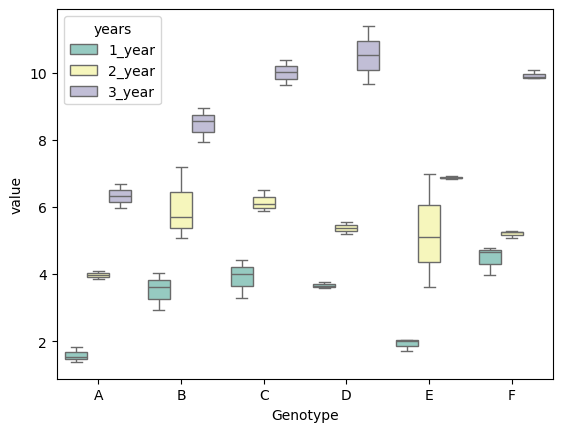

In [16]:
# generate a boxplot to see the data distribution by genotypes and years. Using boxplot, we can easily detect the 
# differences between different groups
sns.boxplot(x="Genotype", y="value", hue="years", data=d_melt, palette="Set3") 


In [23]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('value ~ C(Genotype) + C(years) + C(Genotype):C(years)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table




,sum_sq,df,F,PR(>F)
C(Genotype),58.551733,5.0,32.748581,1.931655e-12
C(years),278.925633,2.0,390.014868,4.006243e-25
C(Genotype):C(years),17.122967,10.0,4.788525,2.230094e-04
Residual,12.873000,36.0,NaN,NaN


In [24]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=d_melt, res_var='value', anova_model='value~C(Genotype)+C(years)+C(Genotype):C(years)')
res.anova_summary


,df,sum_sq,mean_sq,F,PR(>F)
C(Genotype),5.0,58.551733,11.710347,32.748581,1.931655e-12
C(years),2.0,278.925633,139.462817,390.014868,4.006243e-25
C(Genotype):C(years),10.0,17.122967,1.712297,4.788525,2.230094e-04
Residual,36.0,12.873000,0.357583,NaN,NaN


In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

iris_obj = load_iris()
iris_df = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names)

iris_df["species"] = [iris_obj.target_names[s] for s in iris_obj.target]
iris_df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [2]:
species = np.unique(iris_df.species)

data = []

for s in species:
    data.append(iris_df[iris_df.species == s]["sepal length (cm)"])

data

[0     5.1
 1     4.9
 2     4.7
 3     4.6
 4     5.0
 5     5.4
 6     4.6
 7     5.0
 8     4.4
 9     4.9
 10    5.4
 11    4.8
 12    4.8
 13    4.3
 14    5.8
 15    5.7
 16    5.4
 17    5.1
 18    5.7
 19    5.1
 20    5.4
 21    5.1
 22    4.6
 23    5.1
 24    4.8
 25    5.0
 26    5.0
 27    5.2
 28    5.2
 29    4.7
 30    4.8
 31    5.4
 32    5.2
 33    5.5
 34    4.9
 35    5.0
 36    5.5
 37    4.9
 38    4.4
 39    5.1
 40    5.0
 41    4.5
 42    4.4
 43    5.0
 44    5.1
 45    4.8
 46    5.1
 47    4.6
 48    5.3
 49    5.0
 Name: sepal length (cm), dtype: float64,
 50    7.0
 51    6.4
 52    6.9
 53    5.5
 54    6.5
 55    5.7
 56    6.3
 57    4.9
 58    6.6
 59    5.2
 60    5.0
 61    5.9
 62    6.0
 63    6.1
 64    5.6
 65    6.7
 66    5.6
 67    5.8
 68    6.2
 69    5.6
 70    5.9
 71    6.1
 72    6.3
 73    6.1
 74    6.4
 75    6.6
 76    6.8
 77    6.7
 78    6.0
 79    5.7
 80    5.5
 81    5.5
 82    5.8
 83    6.0
 84    5.4
 85    6.0
 86    6.7
 

In [3]:
from scikit_posthocs import posthoc_tukey
from scipy import stats

# First we do a oneway ANOVA as implemented in SciPy
print(stats.f_oneway(*data))

tukey_df = posthoc_tukey(iris_df, val_col="sepal length (cm)", group_col="species")
tukey_df


F_onewayResult(statistic=119.26450218450468, pvalue=1.6696691907693826e-31)


,setosa,versicolor,virginica
setosa,1.000,0.001,0.001
versicolor,0.001,1.000,0.001
virginica,0.001,0.001,1.000


In [4]:
remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan

molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df


,index,variable,value
3,setosa,versicolor,0.001
6,setosa,virginica,0.001
7,versicolor,virginica,0.001


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

setosa vs. versicolor: Custom statistical test, P_val:1.000e-03
versicolor vs. virginica: Custom statistical test, P_val:1.000e-03
setosa vs. virginica: Custom statistical test, P_val:1.000e-03


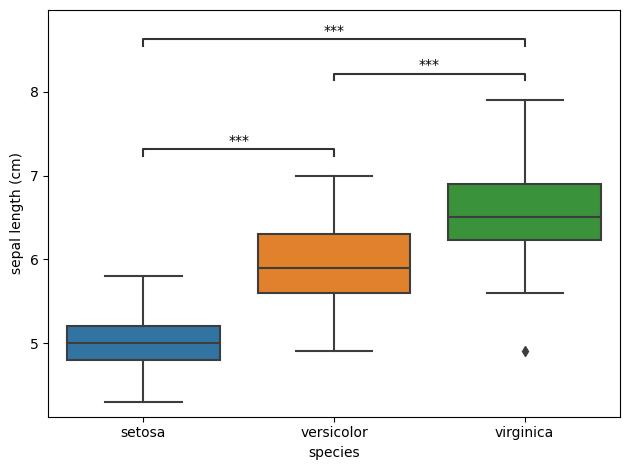

In [6]:
import seaborn as sns
from statannotations.Annotator import Annotator

ax = sns.boxplot(data=iris_df, x="species", y="sepal length (cm)", order=species)

pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]
p_values = [i[1]["value"] for i in molten_df.iterrows()]

annotator = Annotator(
    ax, pairs, data=iris_df, x="species", y="sepal length (cm)", order=species
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)

plt.tight_layout()


In [5]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import f_oneway
from scikit_posthocs import posthoc_tukey



DATA_PATH = 'data/dados_para_teste.csv'
METRIC = 'Test accuracy'

In [8]:
data = pd.read_csv(path.join('..', DATA_PATH))
data.head()

,n,classifier,cnn,Training accuracy,Test accuracy,Training recall,Test recall,Training precision,Test precision,Training f1 Score,Test f1 Score
0,0,RANDON FOREST,inceptionv3,99.0,97.32,100.0,96.44,97.29,96.29,95.0,96.0
1,1,RANDON FOREST,inceptionv3,100.0,97.32,98.0,98.44,97.29,98.29,99.0,98.0
2,2,RANDON FOREST,inceptionv3,100.0,97.32,100.0,97.44,97.29,97.29,97.0,97.0
3,3,RANDON FOREST,inceptionv3,100.0,97.32,99.0,97.94,97.29,97.79,98.0,97.5
4,4,RANDON FOREST,inceptionv3,99.5,97.32,100.0,96.94,97.29,96.79,96.0,96.5


In [9]:
data.shape

(10400, 11)

<Axes: >

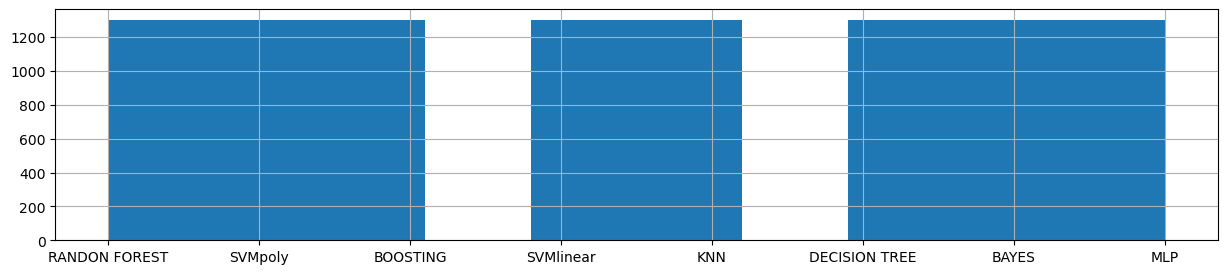

In [10]:
plt.figure(figsize=(15,3))
data['classifier'].hist()

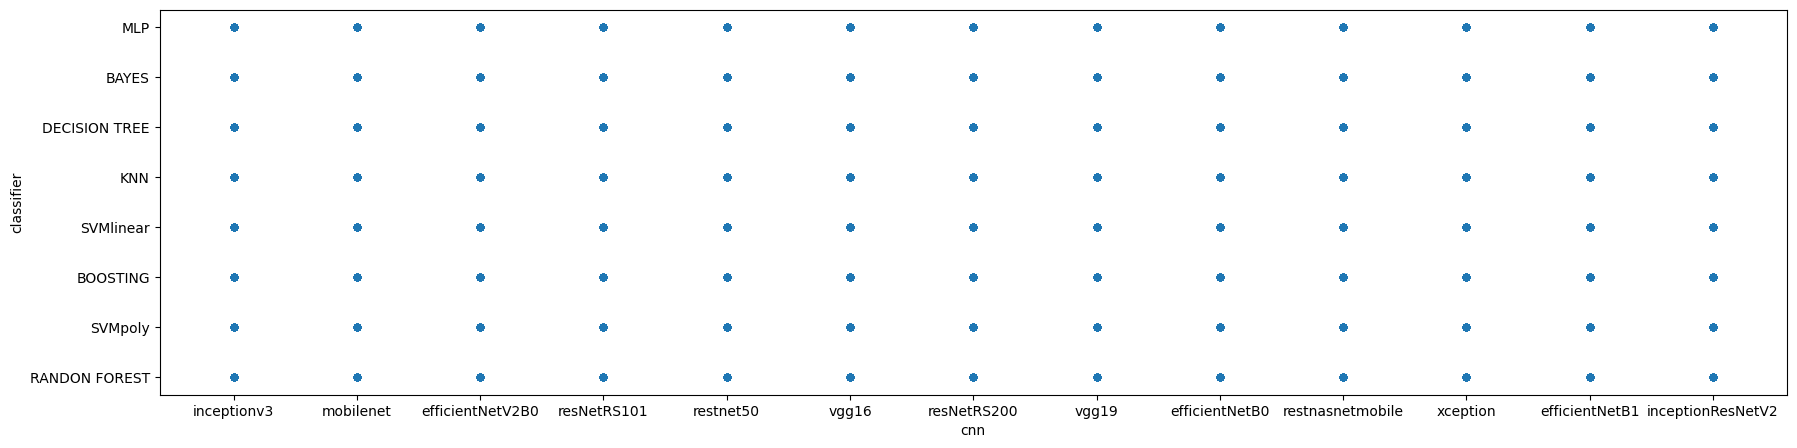

In [11]:
ax = data.plot(x='cnn', y='classifier', kind='scatter')
fig = plt.gcf()
fig.set_size_inches(21, 5)

In [12]:
groups_cnn = data.groupby('cnn')
groups_cnn.groups.keys()

dict_keys(['efficientNetB0', 'efficientNetB1', 'efficientNetV2B0', 'inceptionResNetV2', 'inceptionv3', 'mobilenet', 'resNetRS101', 'resNetRS200', 'restnasnetmobile', 'restnet50', 'vgg16', 'vgg19', 'xception'])

In [13]:
grousp_clf = groups_cnn.get_group('inceptionv3').groupby('classifier')
grousp_clf.groups.keys()

dict_keys(['BAYES', 'BOOSTING', 'DECISION TREE', 'KNN', 'MLP', 'RANDON FOREST', 'SVMlinear', 'SVMpoly'])

In [14]:
f_value, p_value = f_oneway(*(grousp_clf.get_group(group)['Test accuracy'] for group in grousp_clf.groups.keys()))

In [15]:
import pandas as pd
from scipy.stats import f_oneway

def one_way_anova(*groups):
    # Perform one-way ANOVA
    f_value, p_value = f_oneway(*groups)

    # Calculate SS, DF, and MS
    n_groups = len(groups)
    total_ss = sum(sum(group) ** 2 for group in groups) - sum(sum(group) for group in groups) ** 2 / sum(len(group) for group in groups)
    ss_between = sum(sum(group) ** 2 / len(group) for group in groups) - sum(sum(group) for group in groups) ** 2 / sum(len(group) for group in groups)
    ss_within = total_ss - ss_between
    df_between = n_groups - 1
    df_within = sum(len(group) for group in groups) - n_groups
    ms_between = ss_between / df_between
    ms_within = ss_within / df_within

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Source of Variation': ['Between Groups', 'Within Groups', 'Total'],
        'Sum of Squares (SS)': [ss_between, ss_within, total_ss],
        'Degrees of Freedom (DF)': [df_between, df_within, df_between + df_within],
        'Mean Squares (MS)': [ms_between, ms_within, None],
        'F-value': [f_value, None, None],
        'p-value': [p_value, None, None]
    })

    return results_df

# Sample data
group1 = [1, 2, 3, 4, 5]
group2 = [6, 7, 8, 9, 10]
group3 = [11, 12, 13, 14, 15]

# Perform one-way ANOVA with variable number of groups
anova_results = one_way_anova(group1, group2, group3)

# Display the results
anova_results


,Source of Variation,Sum of Squares (SS),Degrees of Freedom (DF),Mean Squares (MS),F-value,p-value
0,Between Groups,250.0,2,125.000000,50.0,0.000002
1,Within Groups,4840.0,12,403.333333,NaN,NaN
2,Total,5090.0,14,NaN,NaN,NaN


In [16]:
anova_results = one_way_anova(*(grousp_clf.get_group(group)['Test accuracy'] for group in grousp_clf.groups.keys()))
anova_results

,Source of Variation,Sum of Squares (SS),Degrees of Freedom (DF),Mean Squares (MS),F-value,p-value
0,Between Groups,6.888674e+04,7,9840.962679,42824.409019,0.0
1,Within Groups,5.528724e+08,792,698071.206250,NaN,NaN
2,Total,5.529413e+08,799,NaN,NaN,NaN


In [17]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Source of Variation': ['Between Groups'],
    'Sum of Squares (SS)': [None],
    'Degrees of Freedom (DF)': [None],
    'Mean Squares (MS)': [None],
    'F-value': [f_value],
    'p-value': [p_value]
})

# Display the results
results_df

,Source of Variation,Sum of Squares (SS),Degrees of Freedom (DF),Mean Squares (MS),F-value,p-value
0,Between Groups,None,None,None,42824.409019,0.0


In [18]:
def plot_anova_results(*groups):
    # Perform one-way ANOVA
    f_value, p_value = f_oneway(*groups)

    # Prepare data for plotting
    group_names = [f'Group {i+1}' for i in range(len(groups))]
    group_means = [group.mean() for group in groups]

    # Plot the means
    plt.bar(group_names, group_means)

    # Add labels and title
    plt.xlabel('Groups')
    plt.ylabel('Means')
    plt.title('ANOVA Results')

    # Add ANOVA result text
    plt.text(len(groups) // 2, max(group_means) * 0.9, f'F-value: {f_value:.2f}\np-value: {p_value:.4f}',
             ha='center', va='center', fontsize=12)

    # Show the plot
    plt.show()

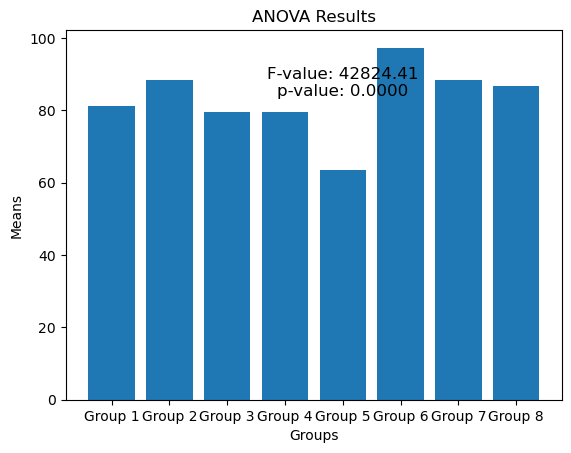

In [19]:
plot_anova_results(*(grousp_clf.get_group(group)['Test accuracy'] for group in grousp_clf.groups.keys()))

In [20]:
tukey_df = posthoc_tukey(groups_cnn.get_group('inceptionv3'), val_col="Test accuracy", group_col="classifier")
tukey_df

,RANDON FOREST,SVMlinear,BOOSTING,SVMpoly,BAYES,KNN,DECISION TREE,MLP
RANDON FOREST,1.000,0.001,0.001,0.001,0.001,0.001,0.001,0.001
SVMlinear,0.001,1.000,0.900,0.001,0.001,0.001,0.001,0.001
BOOSTING,0.001,0.900,1.000,0.001,0.001,0.001,0.001,0.001
SVMpoly,0.001,0.001,0.001,1.000,0.001,0.001,0.001,0.001
BAYES,0.001,0.001,0.001,0.001,1.000,0.001,0.001,0.001
KNN,0.001,0.001,0.001,0.001,0.001,1.000,0.900,0.001
DECISION TREE,0.001,0.001,0.001,0.001,0.001,0.900,1.000,0.001
MLP,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1.000


In [21]:
remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan

molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df

,index,variable,value
8,RANDON FOREST,SVMlinear,0.001
16,RANDON FOREST,BOOSTING,0.001
17,SVMlinear,BOOSTING,0.900
24,RANDON FOREST,SVMpoly,0.001
25,SVMlinear,SVMpoly,0.001
26,BOOSTING,SVMpoly,0.001
32,RANDON FOREST,BAYES,0.001
33,SVMlinear,BAYES,0.001
34,BOOSTING,BAYES,0.001
35,SVMpoly,BAYES,0.001


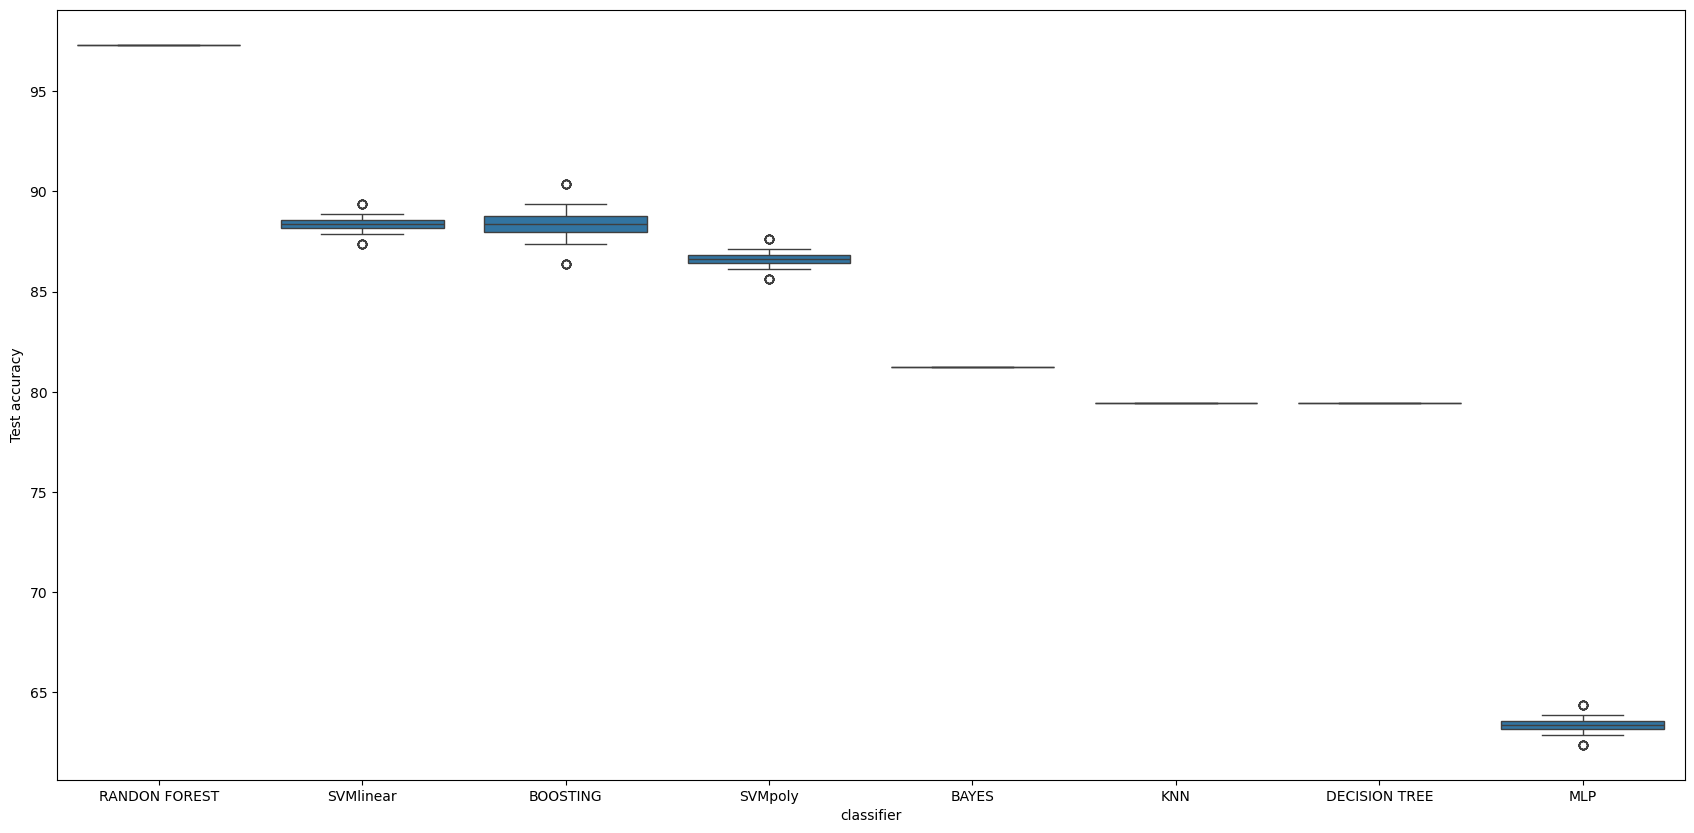

In [22]:
ax = sns.boxplot(data=groups_cnn.get_group('inceptionv3'), x="classifier", y="Test accuracy")
fig = plt.gcf()
fig.set_size_inches(21, 10)

In [34]:
# Step 1: Inspect the 'inceptionv3' group
inceptionv3_group = groups_cnn.get_group('inceptionv3')
print(inceptionv3_group.head())

# Step 2: Ensure 'Test accuracy' column is numeric
# Convert 'Test accuracy' to numeric, forcing any errors to NaN
inceptionv3_group['Test accuracy'] = pd.to_numeric(inceptionv3_group['Test accuracy'], errors='coerce')

# Step 3: Group by 'classifier' and calculate mean, then sort by 'Test accuracy'
sorted_models = inceptionv3_group.groupby('classifier').agg({'Test accuracy': 'mean'}).sort_values('Test accuracy', ascending=False)

print(sorted_models)
sorted_models

   n     classifier          cnn  Training accuracy  Test accuracy  \
0  0  RANDON FOREST  inceptionv3               99.0          97.32   
1  1  RANDON FOREST  inceptionv3              100.0          97.32   
2  2  RANDON FOREST  inceptionv3              100.0          97.32   
3  3  RANDON FOREST  inceptionv3              100.0          97.32   
4  4  RANDON FOREST  inceptionv3               99.5          97.32   

   Training recall  Test recall  Training precision  Test precision  \
0            100.0        96.44               97.29           96.29   
1             98.0        98.44               97.29           98.29   
2            100.0        97.44               97.29           97.29   
3             99.0        97.94               97.29           97.79   
4            100.0        96.94               97.29           96.79   

   Training f1 Score  Test f1 Score  
0               95.0           96.0  
1               99.0           98.0  
2               97.0           97.0  


/var/folders/4d/7pshjxj13f91ntw0zt1jz2br0000gn/T/ipykernel_4681/226969647.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inceptionv3_group['Test accuracy'] = pd.to_numeric(inceptionv3_group['Test accuracy'], errors='coerce')


,Test accuracy
classifier,
RANDON FOREST,97.32
BOOSTING,88.39
SVMlinear,88.39
SVMpoly,86.61
BAYES,81.25
DECISION TREE,79.46
KNN,79.46
MLP,63.39


In [25]:
sorted_models = groups_cnn.get_group('inceptionv3').groupby('classifier').agg(['mean'])['Test accuracy', 'mean'].sort_values(ascending=False)
best_model_name = sorted_models.index[0]

TypeError: agg function failed [how->mean,dtype->object]

In [24]:
filter_list = [('inceptionv3', best_model_name), ('restnet50', 'MLP'), ('vgg16', 'MLP')]
filter_list

NameError: name 'best_model_name' is not defined

In [187]:
filtered_data = data[data.apply(lambda row: tuple(row[['cnn', 'classifier']]), axis=1).isin(filter_list)]
filtered_data


,n,classifier,cnn,Training accuracy,Test accuracy,Training recall,Test recall,Training precision,Test precision,Training f1 Score,Test f1 Score
0,0,RANDON FOREST,inceptionv3,99.0,97.32,100.0,96.44,97.29,96.29,95.0,96.0
1,1,RANDON FOREST,inceptionv3,100.0,97.32,98.0,98.44,97.29,98.29,99.0,98.0
2,2,RANDON FOREST,inceptionv3,100.0,97.32,100.0,97.44,97.29,97.29,97.0,97.0
3,3,RANDON FOREST,inceptionv3,100.0,97.32,99.0,97.94,97.29,97.79,98.0,97.5
4,4,RANDON FOREST,inceptionv3,99.5,97.32,100.0,96.94,97.29,96.79,96.0,96.5
...,...,...,...,...,...,...,...,...,...,...,...
10395,10395,MLP,restnet50,78.0,81.00,78.0,79.00,82.00,81.00,79.0,79.0
10396,10396,MLP,restnet50,80.0,81.00,81.0,79.00,79.00,81.00,81.0,81.0
10397,10397,MLP,restnet50,79.0,78.00,82.0,79.00,81.00,79.00,80.0,81.0
10398,10398,MLP,restnet50,79.0,79.00,78.0,79.00,79.00,79.00,80.0,79.0


In [188]:
tukey_df = posthoc_tukey(filtered_data, val_col="Test accuracy", group_col="cnn")
tukey_df

,inceptionv3,vgg16,restnet50
inceptionv3,1.000,0.001000,0.001000
vgg16,0.001,1.000000,0.300946
restnet50,0.001,0.300946,1.000000


In [189]:
tukey_test = pairwise_tukeyhsd(filtered_data['Test accuracy'], filtered_data['cnn'])
tukey_test._results_table

group1,group2,meandiff,p-adj,lower,upper,reject
inceptionv3,restnet50,-17.42,0.0,-17.7376,-17.1024,True
inceptionv3,vgg16,-17.62,0.0,-17.9376,-17.3024,True
restnet50,vgg16,-0.2,0.3004,-0.5176,0.1176,False


In [190]:
df = pd.DataFrame(data=tukey_test._results_table.data[1:], columns=tukey_test._results_table.data[0])
df


,group1,group2,meandiff,p-adj,lower,upper,reject
0,inceptionv3,restnet50,-17.42,0.0000,-17.7376,-17.1024,True
1,inceptionv3,vgg16,-17.62,0.0000,-17.9376,-17.3024,True
2,restnet50,vgg16,-0.20,0.3004,-0.5176,0.1176,False
